# Predicting betrayal using features and time

We are provided with a dataset that contains a collection of interaction sequences between allies in online Diplomacy games. A sequence consists of consecutive game seasons during which the two players exchange messages and help each other in the game.
Half of the sequences end with betrayal, while the other half are part of Lasting friendships.

In the paper "Linguistic Harbingers of Betrayal", the authors made some analysis to detect cues that can predicit un upcoming betrayal in a game. Th authors also used a Logistic regression model to predict betrayal and got a 57% cross-validation accuracy. 

Our goal is to use other methods, Reccurent Neural Networks(RNN), that are well suited for handling text tasks. We will in fact use RNNs with LSTM layers to take advantage of their memory power for better predictions.


## Load and Explore the dataset

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import json
from metrics import *

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dropout
from keras import regularizers
from keras.layers import BatchNormalization

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import seaborn as sns

In [4]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
#set the diplomacy data folder name
DATA_FOLDER = 'data_diplomacy'

#set the path for the diplomacy dataset using os.path.join to gurantee that it work on the different operating systems
DIPLOMACY_DATASET= os.path.join(DATA_FOLDER, "diplomacy_data.json")


#load the diplomacy dataset using the json method
with open(DIPLOMACY_DATASET, "r") as f:
    diplomacy = json.load(f)
    
#create a dataframe for the diplomacy dataset, will be used for visualization    
df_diplomacy = pd.DataFrame(diplomacy)

In [7]:
print('shape of the diplomacy dataset:', len(df_diplomacy))

shape of the diplomacy dataset: 500


In [8]:
print('some entries:')
df_diplomacy.sample(10)

some entries:


,seasons,game,betrayal,idx,people
387,"[{'season': 1912.0, 'interaction': {'victim': ...",152,False,387,GR
274,"[{'season': 1903.5, 'interaction': {'victim': ...",160,True,274,AR
375,"[{'season': 1907.5, 'interaction': {'victim': ...",69,False,375,AI
20,"[{'season': 1906.0, 'interaction': {'victim': ...",189,True,20,TR
144,"[{'season': 1910.5, 'interaction': {'victim': ...",164,False,144,AT
260,"[{'season': 1908.5, 'interaction': {'victim': ...",203,True,260,RT
34,"[{'season': 1907.5, 'interaction': {'victim': ...",270,False,34,EF
294,"[{'season': 1905.0, 'interaction': {'victim': ...",207,False,294,RT
244,"[{'season': 1904.5, 'interaction': {'victim': ...",275,False,244,RT
15,"[{'season': 1904.0, 'interaction': {'victim': ...",166,False,15,FR


After exploring the dataset, we found that all the features that the authors used are either already computed for each message or can be computed using some specific entries in the dataset.
For each season we can find in the messages entry fro the betrayer and the victim respectively:    
***-'sentiment':*** it contains the values for the positive, negative and neutral sentiments       
***-'lexicon_words':*** contains multpiple entries:     
&emsp;&emsp;***-'allsubj':*** words to compute the subjectivity feature    
&emsp;&emsp;***-'premise':*** words to compute the premise feature     
&emsp;&emsp;***-'claim':*** words to compute the claim feature    
&emsp;&emsp;***-'disc_expansion':*** words to compute the expansion feature    
&emsp;&emsp;***-'disc_comparison':*** words to compute the comparison feature    
&emsp;&emsp;***-'disc_temporal_future':*** words to compute the planning feature    
&emsp;&emsp;***-'disc_temporal_rest':*** words to compute the temporal feature    
&emsp;&emsp;***-'disc_contingency_set':*** words to contingency the temporal feature   
***-'n_requests':*** contains the number of requests    
***-'frequent_words':*** the frequent words    
***-'n_words':*** contains the number of words     
***-'politeness':*** containss the politeness of the message      
***-'n_sentences':*** contains the number of sentences     

According to paper, the ***talkativeness*** is quantified with the number of messages sent, the average number of sentences per message, and the average number of words per sentence
    

## Extract the Features

In [11]:
#set the features names 
features = ['positive', 'negative', 'disc_contingency', 'neutral', 'allsubj', 'premise', 'claim', 'disc_expansion', 'disc_comparison', 'disc_temporal_future', 'disc_temporal_rest', 'n_requests', 'n_words', 'politeness', 'n_sentences', 'traitor']

def iter_features(dataset, feature, lexicon=False): 
    """
    We create an iterator over the datasets messages and features
    """
    
    for game in dataset:
        for season in game["seasons"]:
            for _, messages in season["messages"].items():
                for message in messages:
                    m = message["lexicon_words"].get(feature, [""]) if lexicon else message.get[feature]
                    yield m
                

def make_mappings(m): 
    """
    We create some kind of mapping between words and integers
    """
    idx_to_word = list(set(m))
    word_to_idx = {y:x for x, y in dict(enumerate(idx_to_word)).items()}
    return idx_to_word, word_to_idx


def get_lexicon_feature_vocabulary(dataset, feature):
    """
    gets the lexicon of a feature from the dataset
    """
    return [i for x in iter_features(dataset, feature, lexicon=True) for i in x]


Now we extract the sets of features that were found by the authors in the diplomacy dataset, we will use them later for the preprocessing of the second dataset, the dataset of True and Fake news.

In [12]:
#extract the set of premises from the diplomacy dataset
premises_set = set(get_lexicon_feature_vocabulary( diplomacy, 'premise'))

#remove empty entry
premises_set.remove("") 

#print the set
premises_set

{'after all',
 'as',
 'assuming that',
 'because',
 'besides',
 'deduced',
 'due to',
 'firstly',
 'for',
 'furthermore',
 'given that',
 'in addition',
 'in light of',
 'in that',
 'in view of',
 'is supported by',
 'moreover',
 'secondly',
 'whereas'}

In [13]:
#extract the set of claims from the diplomacy dataset
claims_set= set(get_lexicon_feature_vocabulary( diplomacy, 'claim'))

#remove empty entry
claims_set.remove("")

#print the set
claims_set

{'accordingly',
 'as a result',
 'clearly',
 'conclude that',
 'consequently',
 'entails',
 'hence',
 'however',
 'implies',
 'in conclusion',
 'in fact',
 'in my opinion',
 'in short',
 'indicates that',
 'must be that',
 'on the contrary',
 'shows that',
 'so',
 'suggests that',
 'the truth of the matter',
 'therefore',
 'thus',
 'to sum up'}

In [14]:
#extract the set of the expansion discourse connectros from the diplomacy dataset
disc_expansion_set = set(get_lexicon_feature_vocabulary( diplomacy, 'disc_expansion'))

#remove empty entry
disc_expansion_set.remove("")

#print the set
disc_expansion_set

{'additionally',
 'also',
 'alternatively',
 'although',
 'as an alternative',
 'as if',
 'as though',
 'as well',
 'besides',
 'either or',
 'else',
 'except',
 'finally',
 'for example',
 'for instance',
 'further',
 'furthermore',
 'however',
 'in addition',
 'in fact',
 'in other words',
 'in particular',
 'in short',
 'in the end',
 'in turn',
 'indeed',
 'instead',
 'later',
 'lest',
 'likewise',
 'meantime',
 'meanwhile',
 'moreover',
 'much as',
 'next',
 'nonetheless',
 'nor',
 'on the other hand',
 'otherwise',
 'overall',
 'plus',
 'rather',
 'separately',
 'similarly',
 'specifically',
 'then',
 'ultimately',
 'unless',
 'until',
 'when',
 'while',
 'yet'}

In [15]:
#extract the set of the contingency discourse connectros from the diplomacy dataset
disc_contingency_set =  set(get_lexicon_feature_vocabulary( diplomacy, 'disc_contingency'))

#remove empty entry
disc_contingency_set.remove("")

#print the set
disc_contingency_set

{'accordingly',
 'as a result',
 'as long as',
 'because',
 'consequently',
 'hence',
 'if and when',
 'if then',
 'in the end',
 'in turn',
 'indeed',
 'insofar as',
 'lest',
 'now that',
 'once',
 'since',
 'so that',
 'then',
 'thereby',
 'therefore',
 'thus',
 'unless',
 'until',
 'when'}

In [16]:
#extract the set of the comparaison discourse connectros from the diplomacy dataset
disc_comparison_set =  set(get_lexicon_feature_vocabulary( diplomacy, 'disc_comparison'))

#remove empty entry
disc_comparison_set.remove("")

#print the set
disc_comparison_set

{'after',
 'although',
 'as if',
 'as though',
 'besides',
 'conversely',
 'earlier',
 'however',
 'in fact',
 'in the end',
 'indeed',
 'instead',
 'meanwhile',
 'much as',
 'nevertheless',
 'nonetheless',
 'nor',
 'on the contrary',
 'on the other hand',
 'previously',
 'rather',
 'regardless',
 'still',
 'then',
 'though',
 'when',
 'whereas',
 'while',
 'yet'}

In [17]:
#extract the set of the temporal future discourse connectors from the diplomacy dataset
disc_temporal_future_set =  set(get_lexicon_feature_vocabulary( diplomacy, 'disc_temporal_future'))

#remove empty entry
disc_temporal_future_set.remove("")

#print the set
disc_temporal_future_set

{'after',
 'afterward',
 'as soon as',
 'by then',
 'finally',
 'in the end',
 'later',
 'next',
 'once',
 'then',
 'thereafter',
 'till',
 'ultimately',
 'until'}

In [18]:
#extract the set of the remaining temporal discourse connectros from the diplomacy dataset
disc_temporal_rest_set =  set(get_lexicon_feature_vocabulary( diplomacy, 'disc_temporal_rest'))

#remove empty entry
disc_temporal_rest_set.remove("")

#print the set
disc_temporal_rest_set

{'also',
 'as long as',
 'before',
 'earlier',
 'in turn',
 'meantime',
 'meanwhile',
 'now that',
 'previously',
 'simultaneously',
 'since',
 'still',
 'when',
 'while'}

In [19]:
#extract the set subjective words from the diplomacy dataset
allsubj_set =  set(get_lexicon_feature_vocabulary( diplomacy, 'allsubj'))

#remove empty entry
allsubj_set.remove("")

#print the set
allsubj_set

{'havoc',
 'disappointed',
 'mediocre',
 'central',
 'abandon',
 'damaging',
 'bleak',
 'syndrome',
 'manageable',
 'readily',
 'clean',
 'flaw',
 'preference',
 'indeed',
 'insulted',
 'cut',
 'respectfully',
 'bask',
 'impatiently',
 'understand',
 'blunders',
 'position',
 'nightmare',
 'asinine',
 'cogitate',
 'comfortably',
 'miserable',
 'floundering',
 'honor',
 'alert',
 'interest',
 'authentic',
 'dirty',
 'concur',
 'ineffectiveness',
 'resolved',
 'faze',
 'blast',
 'intact',
 'counterproductive',
 'contemplate',
 'precisely',
 'charming',
 'unclear',
 'fat',
 'itch',
 'dedicated',
 'open',
 'weed',
 'error',
 'screaming',
 'protracted',
 'rogue',
 'heavily',
 'goddamn',
 'dwindle',
 'amicable',
 'rarely',
 'hilariously',
 'ultra',
 'conspicuously',
 'cry',
 'risky',
 'concerned',
 'brilliance',
 'spiteful',
 'harm',
 'rights',
 'patient',
 'irrationally',
 'avalanche',
 'hungry',
 'weirdly',
 'harass',
 'prefer',
 'civil',
 'cannibalize',
 'risk',
 'crass',
 'treacherously'

In [20]:
print( "length of the subjective words set:", len(allsubj_set))

length of the subjective words set: 2617


## RNN model

The goal of our analysis here is to see if analysis using time series can help improve the performance of the model made by the authors.

To make our model comparable to that of the author's we try to use the same dataset and same conventions he used.

In [21]:
#Like the author we only consider in this case the betrayal cases
diplomacy_betrayal = list(filter(lambda x: x["betrayal"], diplomacy))

We will start by preprocessing the dataset for the RNN model

In [23]:
def extract_mean_features_from_season (s, label):
    """
    This is a function that extracts average of the previously mentionned features from a season 
    and puts them in a dataframe with a label indicating if it's the season features are associated 
    with a betrayer or a victim.
    
    args: 
    s which is the season
    label which is either "betrayer" or "victim"
    
    returns:
    
    
    """
    sentiment = pd.DataFrame(map(lambda x: x["sentiment"], s))
    lexicon = pd.DataFrame(map(lambda x: dict(map(lambda y: (y[0], len(y[1])), x["lexicon_words"].items())), s))
    betrayal = pd.DataFrame(np.ones(len(s))*(label=="betrayer"), columns=["traitor"])
    return pd.concat([pd.DataFrame(s).drop(columns=["sentiment", "lexicon_words", "frequent_words"]), sentiment, lexicon, betrayal], axis=1).fillna(0).mean().to_frame().transpose()



def build(game):
    """
    This is a function that builds the final dataframe out of the diplomacy dataset structure
    
    args: game which is the dictionnary instance present in the diplomacy dataset
    
    returns: A fully built dataframe with the desired features.
    
    """
    m = [extract_mean_features_from_season(messages, label) for season in game["seasons"] for label, messages in season["messages"].items() if len(messages) > 0]
    if (len(m)):
        x = pd.concat(m).fillna(0)
        ### check for missing features
        for feature in features:
            if (not feature in x.columns): 
                x[feature] = np.zeros(x.shape[0])
            
        return x[x["traitor"]==0].reset_index(drop=True), x[x["traitor"]==1].reset_index(drop=True) 
    return pd.DataFrame()


#X (our training dataset) is list of the mean of the message features per season where in 
#the index 2*i you will find the victim's series and index 2*i+1 the betrayer's series for game i
X = [i for x in map(build, diplomacy_betrayal) for i in x if len(i) > 0]

print("length of the training dataset:", len(X))

length of the training dataset: 397


In [24]:
# This is a list of the mean of the message features per season where in 
# the index 2*i you will find the victim's series and index 2*i+1 the betrayer's series for game i

#visualize an entry
X[0]

,n_requests,n_words,politeness,n_sentences,positive,neutral,negative,allsubj,premise,disc_expansion,disc_comparison,disc_temporal_future,claim,disc_temporal_rest,disc_contingency,traitor
0,3.250000,120.000000,0.809993,7.750000,1.500000,1.250000,5.000000,17.000000,4.750000,1.0,1.250000,1.000000,0.500000,1.250000,0.250000,0.0
1,0.666667,31.000000,0.785508,3.000000,1.333333,0.666667,1.000000,4.666667,0.333333,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,3.666667,120.000000,0.607331,9.333333,1.000000,3.666667,4.666667,14.666667,2.000000,1.0,0.333333,0.333333,0.000000,0.000000,0.333333,0.0
3,0.500000,28.000000,0.571134,3.000000,1.000000,0.000000,2.000000,5.500000,1.000000,1.0,0.500000,1.000000,0.500000,0.500000,0.500000,0.0
4,2.333333,85.333333,0.563423,5.000000,0.666667,1.666667,2.666667,9.333333,1.000000,1.0,0.000000,0.666667,0.333333,0.333333,0.000000,0.0
5,2.000000,53.500000,0.774352,5.500000,1.000000,1.500000,3.000000,12.000000,1.000000,0.5,0.500000,0.000000,0.000000,0.500000,0.500000,0.0
6,1.000000,65.000000,0.341214,7.000000,0.000000,3.000000,4.000000,11.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000,1.000000,0.0
7,0.000000,17.000000,0.630194,2.500000,0.500000,1.000000,1.000000,3.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [25]:
#y (our labels) is list 1 or 0 indicating if the series belongs to a traitor (1) or not (0) 
y = np.array([x["traitor"].iloc[0] for x in X])

#see the y array
y

array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 1.

In [26]:
# Z-score scaling
def normalize(x): 
    df = x.drop(columns="traitor")
    return ((df-df.mean())/df.std()).fillna(0)

#min max scaling
def min_max(x):
    df = x.drop(columns="traitor")
    return ((df-min_df)/(df.max()-min_df)).fillna(0)


# We apply the z-score scaling to the features 
X_scaled = list(map(normalize, X))

#visualize the x_scaled
X_scaled[1]

,n_requests,n_words,politeness,n_sentences,positive,neutral,negative,allsubj,premise,disc_expansion,disc_comparison,disc_temporal_future,claim,disc_temporal_rest,disc_contingency
0,0.345396,0.022332,0.209525,0.190972,0.626529,0.141743,-0.486403,0.148746,0.136091,0.119137,0.545253,-0.052129,-0.263719,-0.178093,-0.312251
1,-1.167839,-0.846505,-1.612562,-1.041861,-0.814596,-0.569195,-0.810972,-1.187956,-0.705567,-0.700141,-0.698079,-0.364900,-0.298941,-0.699339,-0.352091
2,1.510586,1.801876,1.553174,1.720310,1.433559,1.883541,0.270925,1.828737,-0.053961,1.839619,1.995806,2.137273,2.448320,2.011143,2.337149
3,0.048802,0.196099,-0.198919,0.606078,1.191450,-0.654507,0.573856,0.284847,0.174101,1.036727,-0.034969,0.677672,-0.214410,0.551653,0.412848
4,-0.713868,-0.867441,0.927387,-0.573697,0.223014,-0.355913,-1.243731,-0.595554,-0.053961,0.119137,-0.905301,-0.052129,-0.510268,-0.907838,-0.591135
5,-1.137574,-0.937227,-0.106788,-1.229127,-0.987531,-0.853570,-0.738846,-0.914540,-0.814168,-0.645522,-0.905301,-0.781929,-0.510268,-0.421341,-0.312251
6,1.192807,1.079591,0.220113,0.737164,-0.987531,1.137056,1.785581,0.871780,2.226660,-1.027852,0.545253,-0.781929,-0.510268,0.551653,-0.591135
7,-0.078310,-0.448724,-0.991930,-0.409839,-0.684895,-0.729156,0.649589,-0.436061,-0.909194,-0.741105,-0.542662,-0.781929,-0.140445,-0.907838,-0.591135


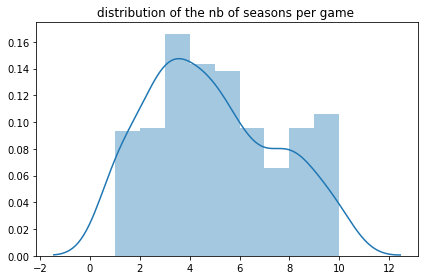

In [27]:
#We plot the distribution of the nb of seasons per game 
season_lengths = list(map(len, X))
sns.distplot(season_lengths)
plt.title("distribution of the nb of seasons per game ")
plt.tight_layout()
plt.show()

As we can see not all games have the same number of seasons, and since the RNN model requires input (in our case the games) of the same size, we will padd the games with empty seasons to have all games with the same length, which is the length of the longest game in our dataset.

In [28]:
# We realize that the seasons don't span for a long time so we take 10 time steps in the RNN
PADDING = max(season_lengths)
print("maximum game length:", PADDING)

maximum game length: 10


In [29]:
def pad_df(x):
    """
    Function to pad every entry PADDING time steps
    """
    z = np.pad(x, ((PADDING - x.shape[0],0), (0,0)))
    return z


#add paddings to the training dataset to have all games with the same length 
X_scaled_padded = np.array([x for x in map(pad_df, X_scaled)])

In [30]:
print("shape of the training dataset after padding:", X_scaled_padded.shape)

shape of the training dataset after padding: (397, 10, 15)


In [31]:
# We repeat the same pre-processing for the games where there was no betrayal. We set all labels to zero
# (we consider both players as players who do not intend to betray thus not traitors)
# This dataset will solely be used for testing purposes to see if the model can detect 
# the non intention of betrayal.

X_no_betrayal = [i for x in map(build, filter(lambda x: not x["betrayal"], diplomacy)) for i in x if len(i) > 0]
X_no_betrayal = np.array(list(map(pad_df, map(normalize, X_no_betrayal))))
y_no_betrayal = np.zeros(len(X_no_betrayal))

In [32]:
# We split the dataset into 90% training and 10% test 
X_train, X_test, y_train, y_test = train_test_split(X_scaled_padded, y, test_size = 0.1)

Now we build our RNN model:

In [66]:
# We build the model now 
model = Sequential()
# A first simple RNN layer with 10 time steps each taking a 15 dimension vector and outputting a 4 dimension vector 
model.add(SimpleRNN(4, input_shape=X_train.shape[1:], kernel_regularizer="l2")

# A sigmoid layer (equivalent to logistic regression) to output the prediction, regularized by elsatic net
model.add(Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(0.1)))

#we compile the model using the MSE loss function, the adam optimizer and the accuracy as a metric
model.compile(loss="mean_squared_error", optimizer='adam', metrics=['acc'])

#print the model summary 
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 4)                 80        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________


In [69]:
#we define an early stopping to stop training the accuracy metric has stopped improving.
early_exit = EarlyStopping(monitor='val_acc', patience=100, verbose=1, mode='max', restore_best_weights=True)

# We train the model with early stopping 
# 90% of the data is used for training and 10% for testing
# we run 600 epochs with batch_size=16
h = model.fit(X_train, y_train, epochs=600, batch_size=16, verbose=0, validation_split = 0.1, callbacks=[early_exit])

Restoring model weights from the end of the best epoch.
Epoch 00108: early stopping


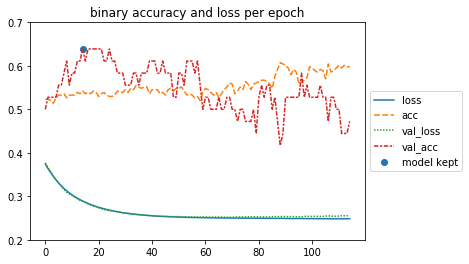

In [56]:
# We get the history from the model
values = pd.DataFrame(h.history)

# We plot the history 
plt.title("binary accuracy and loss per epoch")
plt.ylim((0.2, 0.7))
plt.scatter(values["val_acc"].argmax(), values["val_acc"].max(), label="model kept")
sns.lineplot(data=values)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [61]:
# We print the best validation accuracy
print("validation accuracy: ", values["val_acc"].max())

validation accuracy:  0.6388888955116272


In [70]:
# We evaluate the model on the test set
print("evaluate the model on the test set:", model.evaluate(X_test, y_test))

2/2 [==============================] - 0s 1ms/step - loss: 0.2501 - acc: 0.5500
evaluate the model on the test set: [0.2500642240047455, 0.550000011920929]


In [71]:
# We evaluate the model on the no betrayal dataset
print( "evaluate the model on the no betrayal dataset:" ,model.evaluate(X_no_betrayal, y_no_betrayal))

13/13 [==============================] - 0s 1ms/step - loss: 0.2501 - acc: 0.5797
evaluate the model on the no betrayal dataset: [0.2501254975795746, 0.5797468423843384]


## Conclusion

The model reached an Accuracy of 0.64 on the validation set and an accuracy of 0.55 on the test set. Which is an improvement compared to the authors' results who only got 0.57 on the validation set. Thus harnessing the time evolution of the features can be helpfulto the model.  
However, the model has a lot of trouble converging. We don't have a lot of data, thus to reach convergence we simplify the model to the most we can, we add batch normalization, and regularize quite heavily (high l2 values, early stopping ...). Yet the problem is really complex, thus this simple model cannot fully grasp the decision boundary between betrayal or not for a given time series.      